# Performance benchmark of the keymark heatpump database

In [1]:
import hplib.hplib_database as db
import hplib.performance as perf
import numpy as np
import pandas as pd

Import the relevant data

In [2]:
performance = db.read_performance_data("performance_data.csv",)
meta = db.read_meta_data("meta_data.csv",)

/home/leander/workspace/fzj/hplib/hplib/hplib_database.py:419: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(OUTPUT_FOLDER_PATH +filename, index_col=[0,1,2], sep=';')


Get the season coefficient of performance and filter temperature 55°C (5) and climate average (3)

In [3]:
performance_55_average = performance.loc[(slice(None), 5, 3), :]
performance_55_average.reset_index(level=['temperature', 'climate'], inplace=True)

Get all heatpumps Outdoor Air as source

In [4]:
air_source_hps = meta[meta['Type'] == 'Outdoor Air/Water'].index
len(air_source_hps)

5053

Determine intersection of union between both indices

In [5]:
reduced_set = air_source_hps.intersection(performance_55_average.index.to_list())
len(reduced_set)

5021

Text(0, 0.5, 'Air source heat pump types')

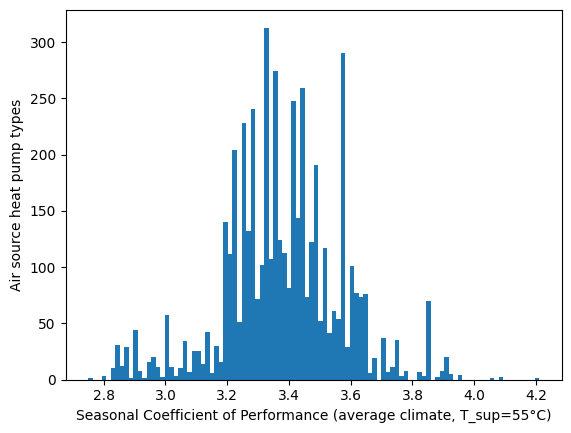

In [6]:
ax = performance_55_average.loc[reduced_set,'scop'].astype(float).plot.hist(bins=100)
ax.set_xlabel("Seasonal Coefficient of Performance (average climate, T_sup=55°C)")
ax.set_ylabel("Air source heat pump types")

Text(0, 0.5, 'Air source heat pump types')

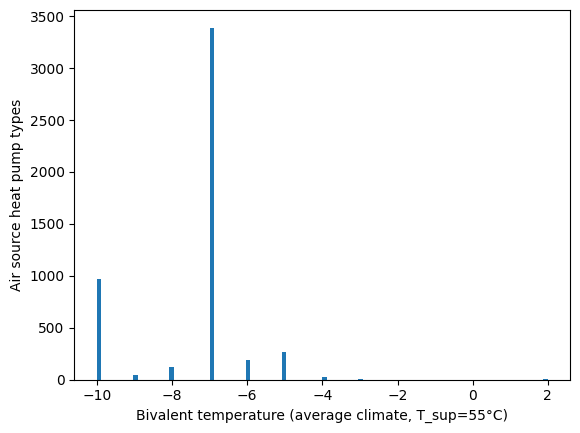

In [7]:
ax = performance_55_average.loc[reduced_set,'t_biv'].astype(float).plot.hist(bins=100)
ax.set_xlabel("Bivalent temperature (average climate, T_sup=55°C)")
ax.set_ylabel("Air source heat pump types")

(0.0, 5.0)

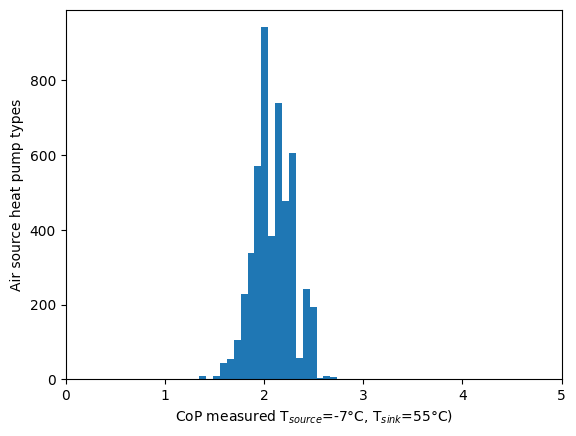

In [8]:
ax = performance_55_average.loc[reduced_set,'cop_minus7'].astype(float).plot.hist(bins=100)
ax.set_xlabel("CoP measured T$_{source}$=-7°C, T$_{sink}$=55°C)")
ax.set_ylabel("Air source heat pump types")
ax.set_xlim(0, 5)

(0.0, 5.0)

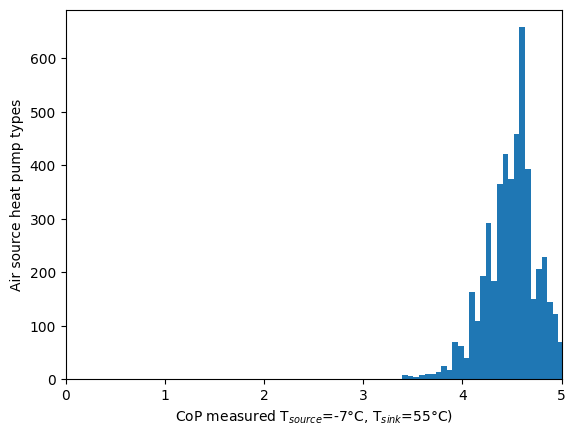

In [9]:
ax = performance_55_average.loc[reduced_set,'cop_7'].astype(float).plot.hist(bins=100)
ax.set_xlabel("CoP measured T$_{source}$=-7°C, T$_{sink}$=55°C)")
ax.set_ylabel("Air source heat pump types")
ax.set_xlim(0, 5)

In [29]:
performance_55_average[["p_rated","p_th_minus7","p_th_7"]]

,p_rated,p_th_minus7,p_th_7
id,,,
ait-deutschland GmbH NOVELAN L8 Split-HV 12,7.00,6.30,2.60
"Qingdao Hisense Hitachi Air-conditioning Systems Co.,Ltd. AHW-060HCDS1/AHS-060HCDSAA-23",3.84,3.40,1.41
Mitsubishi Electric Air Conditioning Systems Europe LTD PUD-SWM60VAA(-BS) + E*SD-*M*D,6.00,5.30,5.30
Mitsubishi Electric Air Conditioning Systems Europe LTD PUD-SWM60VAA(-BS) + E*SD-M*D,6.00,5.30,5.30
Mitsubishi Electric Air Conditioning Systems Europe LTD PUD-SWM60VAA(-BS) + E*ST20D-*M*D,6.00,5.30,5.30
...,...,...,...
DAIKIN Europe N.V. EPRA16DW1 / ETSHB16P30D,12.50,11.10,6.50
DAIKIN Europe N.V. EPRA16DW1 / ETSX16P30D,12.50,11.10,6.50
DAIKIN Europe N.V. EPRA16DW1 / ETSXB16P30D,12.50,11.10,6.50


In [32]:
performance.loc[( " Vaillant Deutschland GmbH & Co KG VWL 125/6 A", slice(None), 3), 'p_th_minus7']

id                                              temperature  climate
 Vaillant Deutschland GmbH & Co KG VWL 125/6 A  4            3          11.27
                                                5            3          10.45
Name: p_th_minus7, dtype: float64

## Performance modeling

Get test field

In [11]:
T_sink_s = [35., 55.]
T_source_s = np.linspace(-20, 15, 100)

In [25]:
pf_results = {}
for T_sink in T_sink_s:
    pf_results[T_sink] = pd.DataFrame(index=T_source_s, columns=['Carnot', 'Schwamberger 1991', 'Schlosser et al. 2020', '2nd degree polynomial'])
    for T_source in T_source_s:
        pf_results[T_sink].loc[T_source, 'Carnot'] = perf.cop_carnot(T_source, T_sink, efficiency_grade = 0.45, b_hp =0)
        pf_results[T_sink].loc[T_source, 'Schwamberger 1991'] = perf.cop_schwamberger(T_source, T_sink)
        pf_results[T_sink].loc[T_source, 'Schlosser et al. 2020'] = perf.cop_schlosser(T_source, T_sink)
        pf_results[T_sink].loc[T_source, '2nd degree polynomial'] = perf.cop_polynomial(T_source, T_sink)
    pf_results[T_sink] = pf_results[T_sink].add_suffix(' $T_{sink}=' + str(T_sink) + '°C$')

And plot results for unfitted parameters

/home/leander/workspace/fzj/hplib/hplib/hplib_database.py:419: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(OUTPUT_FOLDER_PATH +filename, index_col=[0,1,2], sep=';')
/home/leander/workspace/fzj/hplib/hplib/hplib_database.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_performance.rename(index={4: " $T_{sink}=35°C$", 5: " $T_{sink}=55°C$"}, inplace=True)


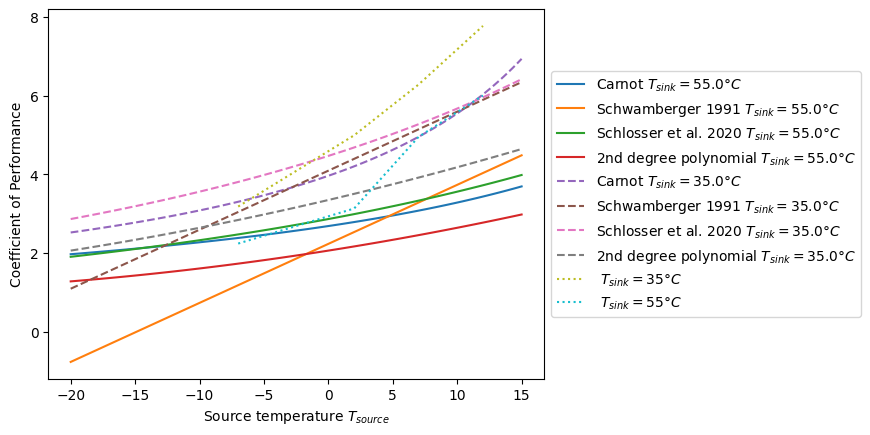

In [26]:
ax = pf_results[55.].plot()
pf_results[35.].plot(ax=ax, style='--')
db.read_single_model_performance(" ELCO GmbH AEROTOP S09.2").plot(ax=ax, style=':')
ax.set_ylabel("Coefficient of Performance")
ax.set_xlabel("Source temperature $T_{source}$")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


## Historic development of the performance

In [14]:
meta["Manufacturer"].str.contains("Viessmann").sum() 

performance_55_average["Manufacturer"] = meta.loc[performance_55_average.index,"Manufacturer"]
performance_55_average["Date"] = pd.to_datetime(meta.loc[performance_55_average.index,"Date"])


/tmp/ipykernel_146599/3359806265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_55_average["Manufacturer"] = meta.loc[performance_55_average.index,"Manufacturer"]
/home/leander/.virtualenvs/tsam/lib/python3.10/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '29.04.2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/leander/.virtualenvs/tsam/lib/python3.10/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '30.11.2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache

Text(0.5, 0, 'Certification date')

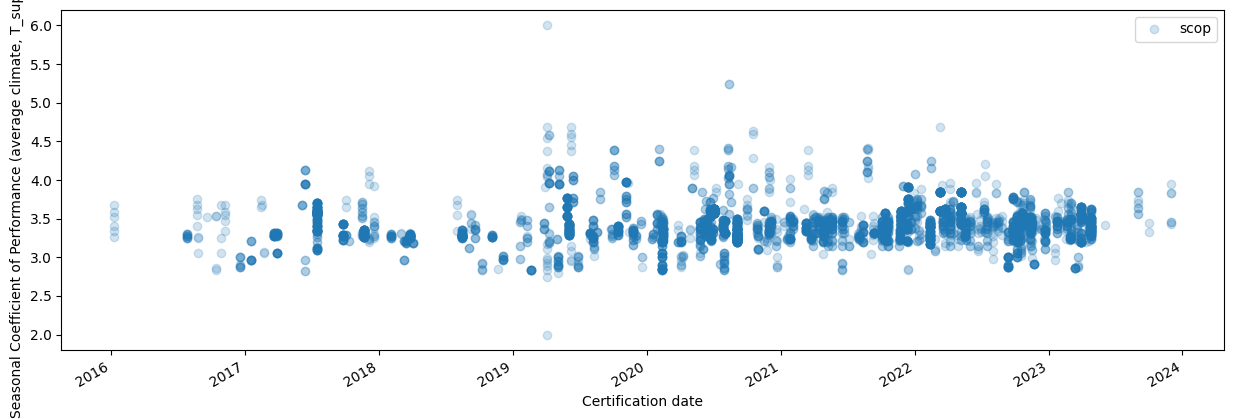

In [15]:
ax = performance_55_average.plot(x="Date", y="scop", style='o', 
                                 alpha=0.2, figsize=(15, 5))
ax.set_ylabel("Seasonal Coefficient of Performance (average climate, T_sup=55°C)")
ax.set_xlabel("Certification date")

In [16]:
performance_55_average.sort_values(by="Date").rolling(100).mean().plot(x="Date", y="scop", style='o')

/tmp/ipykernel_146599/4264812113.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date', 'Manufacturer', 'P_he', 'spl_outdoor', 'supp_energy_types'], dtype='object')
  performance_55_average.sort_values(by="Date").rolling(100).mean().plot(x="Date", y="scop", style='o')


KeyError: 'Date'

In [ ]:
rolling_avg = performance_55_average.sort_values(by="Date").set_index("Date").rolling(100).mean()["scop"].dropna()

/tmp/ipykernel_46333/2495926270.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Manufacturer', 'P_he', 'spl_outdoor', 'supp_energy_types'], dtype='object')
  rolling_avg = performance_55_average.sort_values(by="Date").set_index("Date").rolling(100).mean()["scop"].dropna()


<AxesSubplot: xlabel='Date'>

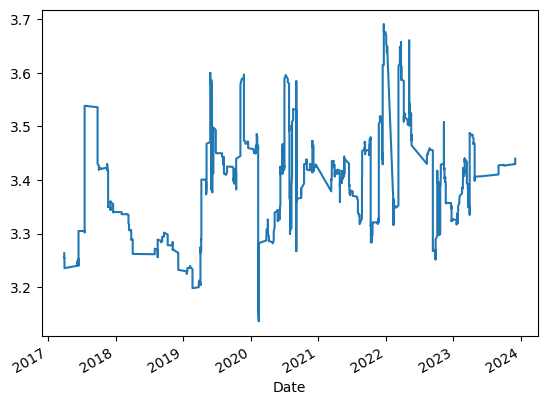

In [ ]:
rolling_avg[rolling_avg.index.dropna()].plot()

In [ ]:
viess_hps = performance_55_average[performance_55_average["Manufacturer"].str.contains("Viessmann")] 


In [ ]:
viess_rolling

Date
2019-11-07    3.4685
2019-11-07    3.5065
2019-11-07    3.5445
2019-11-07    3.5615
2019-11-07    3.5770
               ...  
NaT           3.3445
NaT           3.3490
NaT           3.3490
NaT           3.3490
NaT           3.3430
Name: scop, Length: 341, dtype: float64

In [ ]:
viess_rolling = viess_hps.sort_values(by="Date").set_index("Date").rolling(5).mean()["scop"].dropna()

/tmp/ipykernel_46333/3736962976.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Manufacturer'], dtype='object')
  viess_rolling = viess_hps.sort_values(by="Date").set_index("Date").rolling(5).mean()["scop"].dropna()


In [ ]:
viess_rolling[rolling_avg.index.dropna()].plot()

KeyError: "[Timestamp('2017-03-30 00:00:00'), Timestamp('2017-03-31 00:00:00'), Timestamp('2017-06-07 00:00:00'), Timestamp('2017-06-15 00:00:00'), Timestamp('2017-07-18 00:00:00'), Timestamp('2017-09-26 00:00:00'), Timestamp('2017-10-03 00:00:00'), Timestamp('2017-10-04 00:00:00'), Timestamp('2017-10-13 00:00:00'), Timestamp('2017-11-17 00:00:00'), Timestamp('2017-11-22 00:00:00'), Timestamp('2017-12-05 00:00:00'), Timestamp('2017-12-06 00:00:00'), Timestamp('2017-12-19 00:00:00'), Timestamp('2018-02-03 00:00:00'), Timestamp('2018-03-04 00:00:00'), Timestamp('2018-03-12 00:00:00'), Timestamp('2018-03-26 00:00:00'), Timestamp('2018-03-27 00:00:00'), Timestamp('2018-04-04 00:00:00'), Timestamp('2018-08-01 00:00:00'), Timestamp('2018-08-17 00:00:00'), Timestamp('2018-09-04 00:00:00'), Timestamp('2018-09-10 00:00:00'), Timestamp('2018-09-20 00:00:00'), Timestamp('2018-10-10 00:00:00'), Timestamp('2018-11-06 00:00:00'), Timestamp('2018-11-22 00:00:00'), Timestamp('2018-12-06 00:00:00'), Timestamp('2019-01-21 00:00:00'), Timestamp('2019-01-24 00:00:00'), Timestamp('2019-02-08 00:00:00'), Timestamp('2019-02-21 00:00:00'), Timestamp('2019-03-27 00:00:00'), Timestamp('2019-03-29 00:00:00'), Timestamp('2019-04-05 00:00:00'), Timestamp('2019-04-09 00:00:00'), Timestamp('2019-04-10 00:00:00'), Timestamp('2019-05-03 00:00:00'), Timestamp('2019-05-06 00:00:00'), Timestamp('2019-05-08 00:00:00'), Timestamp('2019-05-28 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-09 00:00:00'), Timestamp('2019-06-14 00:00:00'), Timestamp('2019-06-27 00:00:00'), Timestamp('2019-06-28 00:00:00'), Timestamp('2019-07-31 00:00:00'), Timestamp('2019-08-08 00:00:00'), Timestamp('2019-08-10 00:00:00'), Timestamp('2019-08-20 00:00:00'), Timestamp('2019-08-27 00:00:00'), Timestamp('2019-09-26 00:00:00'), Timestamp('2019-09-30 00:00:00'), Timestamp('2019-10-04 00:00:00'), Timestamp('2019-10-15 00:00:00'), Timestamp('2019-11-12 00:00:00'), Timestamp('2019-11-15 00:00:00'), Timestamp('2019-11-26 00:00:00'), Timestamp('2019-12-04 00:00:00'), Timestamp('2019-12-17 00:00:00'), Timestamp('2019-12-19 00:00:00'), Timestamp('2020-01-17 00:00:00'), Timestamp('2020-01-20 00:00:00'), Timestamp('2020-01-27 00:00:00'), Timestamp('2020-01-30 00:00:00'), Timestamp('2020-02-03 00:00:00'), Timestamp('2020-02-06 00:00:00'), Timestamp('2020-02-12 00:00:00'), Timestamp('2020-02-14 00:00:00'), Timestamp('2020-03-26 00:00:00'), Timestamp('2020-03-27 00:00:00'), Timestamp('2020-04-03 00:00:00'), Timestamp('2020-04-04 00:00:00'), Timestamp('2020-04-09 00:00:00'), Timestamp('2020-04-29 00:00:00'), Timestamp('2020-05-05 00:00:00'), Timestamp('2020-05-10 00:00:00'), Timestamp('2020-05-26 00:00:00'), Timestamp('2020-05-27 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-06-03 00:00:00'), Timestamp('2020-06-07 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-30 00:00:00'), Timestamp('2020-07-01 00:00:00'), Timestamp('2020-07-02 00:00:00'), Timestamp('2020-07-08 00:00:00'), Timestamp('2020-07-20 00:00:00'), Timestamp('2020-07-27 00:00:00'), Timestamp('2020-07-28 00:00:00'), Timestamp('2020-07-29 00:00:00'), Timestamp('2020-08-01 00:00:00'), Timestamp('2020-08-09 00:00:00'), Timestamp('2020-08-12 00:00:00'), Timestamp('2020-09-04 00:00:00'), Timestamp('2020-09-06 00:00:00'), Timestamp('2020-09-30 00:00:00'), Timestamp('2020-10-16 00:00:00'), Timestamp('2020-10-27 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2020-10-31 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-24 00:00:00'), Timestamp('2020-11-30 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-06 00:00:00'), Timestamp('2020-12-18 00:00:00'), Timestamp('2021-03-12 00:00:00'), Timestamp('2021-03-15 00:00:00'), Timestamp('2021-03-25 00:00:00'), Timestamp('2021-03-29 00:00:00'), Timestamp('2021-03-30 00:00:00'), Timestamp('2021-03-31 00:00:00'), Timestamp('2021-04-03 00:00:00'), Timestamp('2021-04-06 00:00:00'), Timestamp('2021-04-14 00:00:00'), Timestamp('2021-04-27 00:00:00'), Timestamp('2021-04-28 00:00:00'), Timestamp('2021-04-29 00:00:00'), Timestamp('2021-05-07 00:00:00'), Timestamp('2021-05-11 00:00:00'), Timestamp('2021-05-20 00:00:00'), Timestamp('2021-05-21 00:00:00'), Timestamp('2021-06-16 00:00:00'), Timestamp('2021-06-18 00:00:00'), Timestamp('2021-06-22 00:00:00'), Timestamp('2021-07-06 00:00:00'), Timestamp('2021-07-30 00:00:00'), Timestamp('2021-08-03 00:00:00'), Timestamp('2021-08-04 00:00:00'), Timestamp('2021-08-09 00:00:00'), Timestamp('2021-08-12 00:00:00'), Timestamp('2021-08-25 00:00:00'), Timestamp('2021-08-26 00:00:00'), Timestamp('2021-09-04 00:00:00'), Timestamp('2021-09-09 00:00:00'), Timestamp('2021-09-11 00:00:00'), Timestamp('2021-09-13 00:00:00'), Timestamp('2021-09-22 00:00:00'), Timestamp('2021-10-03 00:00:00'), Timestamp('2021-10-05 00:00:00'), Timestamp('2021-10-11 00:00:00'), Timestamp('2021-10-12 00:00:00'), Timestamp('2021-10-14 00:00:00'), Timestamp('2021-10-18 00:00:00'), Timestamp('2021-10-21 00:00:00'), Timestamp('2021-10-22 00:00:00'), Timestamp('2021-11-18 00:00:00'), Timestamp('2021-11-22 00:00:00'), Timestamp('2021-11-23 00:00:00'), Timestamp('2021-11-24 00:00:00'), Timestamp('2021-11-30 00:00:00'), Timestamp('2021-12-11 00:00:00'), Timestamp('2021-12-14 00:00:00'), Timestamp('2021-12-21 00:00:00'), Timestamp('2021-12-30 00:00:00'), Timestamp('2022-01-03 00:00:00'), Timestamp('2022-01-06 00:00:00'), Timestamp('2022-01-07 00:00:00'), Timestamp('2022-01-08 00:00:00'), Timestamp('2022-02-11 00:00:00'), Timestamp('2022-02-14 00:00:00'), Timestamp('2022-02-25 00:00:00'), Timestamp('2022-03-10 00:00:00'), Timestamp('2022-03-11 00:00:00'), Timestamp('2022-03-17 00:00:00'), Timestamp('2022-03-18 00:00:00'), Timestamp('2022-03-24 00:00:00'), Timestamp('2022-03-25 00:00:00'), Timestamp('2022-04-08 00:00:00'), Timestamp('2022-04-11 00:00:00'), Timestamp('2022-04-15 00:00:00'), Timestamp('2022-04-26 00:00:00'), Timestamp('2022-04-29 00:00:00'), Timestamp('2022-05-07 00:00:00'), Timestamp('2022-05-08 00:00:00'), Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-19 00:00:00'), Timestamp('2022-05-20 00:00:00'), Timestamp('2022-08-11 00:00:00'), Timestamp('2022-08-15 00:00:00'), Timestamp('2022-08-18 00:00:00'), Timestamp('2022-08-26 00:00:00'), Timestamp('2022-09-12 00:00:00'), Timestamp('2022-09-26 00:00:00'), Timestamp('2022-09-27 00:00:00'), Timestamp('2022-10-06 00:00:00'), Timestamp('2022-10-08 00:00:00'), Timestamp('2022-10-14 00:00:00'), Timestamp('2022-10-17 00:00:00'), Timestamp('2022-10-20 00:00:00'), Timestamp('2022-10-21 00:00:00'), Timestamp('2022-10-24 00:00:00'), Timestamp('2022-10-25 00:00:00'), Timestamp('2022-11-11 00:00:00'), Timestamp('2022-11-14 00:00:00'), Timestamp('2022-11-17 00:00:00'), Timestamp('2022-11-18 00:00:00'), Timestamp('2022-11-21 00:00:00'), Timestamp('2022-11-29 00:00:00'), Timestamp('2022-12-12 00:00:00'), Timestamp('2022-12-19 00:00:00'), Timestamp('2022-12-21 00:00:00'), Timestamp('2022-12-22 00:00:00'), Timestamp('2022-12-26 00:00:00'), Timestamp('2023-01-18 00:00:00'), Timestamp('2023-01-19 00:00:00'), Timestamp('2023-01-23 00:00:00'), Timestamp('2023-01-27 00:00:00'), Timestamp('2023-02-02 00:00:00'), Timestamp('2023-02-04 00:00:00'), Timestamp('2023-02-17 00:00:00'), Timestamp('2023-02-21 00:00:00'), Timestamp('2023-02-22 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-03 00:00:00'), Timestamp('2023-03-04 00:00:00'), Timestamp('2023-03-15 00:00:00'), Timestamp('2023-03-20 00:00:00'), Timestamp('2023-03-22 00:00:00'), Timestamp('2023-04-14 00:00:00'), Timestamp('2023-04-20 00:00:00'), Timestamp('2023-04-26 00:00:00'), Timestamp('2023-06-03 00:00:00'), Timestamp('2023-09-02 00:00:00'), Timestamp('2023-10-02 00:00:00'), Timestamp('2023-12-01 00:00:00')] not in index"

In [ ]:
performance_55_average["scop"].mean()

3.417427104346231